In [1]:
import pandas as pd

import numpy as np

import torch
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim

import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix

import seaborn as sn

import random
import os

In [2]:
sequence_path = "../chr_seq/"
annotation_path = "../combined_annotations.csv"

In [3]:
annotations = pd.read_csv(annotation_path, sep='\t')

In [4]:
annotations['label'] = annotations['label'].replace('junk', 'non-target')

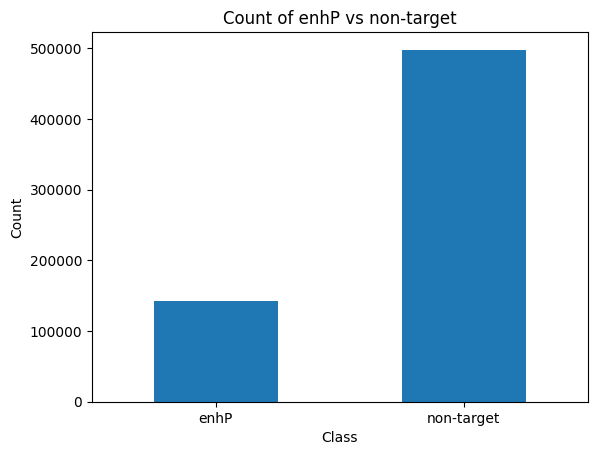

In [5]:
# # Count the occurrences of each class
# class_counts = annotations['label'].value_counts()
# class_counts['rest'] = class_counts.drop('enhD').sum()
# class_counts = class_counts[['enhD', 'rest']]

# # Plot the counts
# class_counts.plot(kind='bar')
# plt.title('Count of enhD vs Rest')
# plt.xlabel('Class')
# plt.ylabel('Count')
# plt.xticks(rotation=0)  # Rotate x-axis labels to show them horizontally
# plt.show()

class_counts = annotations['label'].value_counts()
class_counts = class_counts[['enhP', 'non-target']]

# Plot the counts
class_counts.plot(kind='bar')
plt.title('Count of enhP vs non-target')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(rotation=0)  # Rotate x-axis labels to show them horizontally
plt.show()



In [6]:
annotations=annotations[annotations['label'].isin(['enhP', 'non-target'])]

In [7]:
num_enhP = len(annotations[annotations['label'] == 'enhP'])

nt_annotations_sampled = annotations[annotations['label'] == 'non-target'].sample(n=num_enhP, random_state=42)

# Combine the two sets
annotations = pd.concat([annotations[annotations['label'] == 'enhP'], nt_annotations_sampled])

# Now you can proceed to create your dataset with 'balanced_annotations'
# instead of the full 'annotations' DataFrame

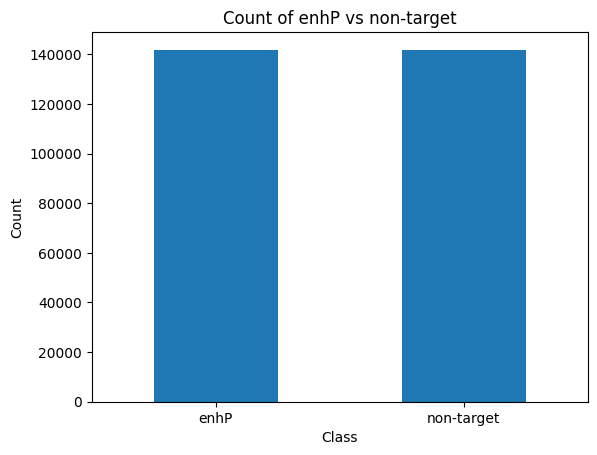

In [8]:
class_counts = annotations['label'].value_counts()

# Plot the counts
class_counts.plot(kind='bar')
plt.title('Count of enhP vs non-target')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(rotation=0)  # Rotate x-axis labels to show them horizontally
plt.show()



In [9]:
annotations.head()

,chrom,frameStart,frameEnd,label
0,chr1,181248,181648,enhP
6,chr1,779668,780068,enhP
16,chr1,817864,818264,enhP
18,chr1,818675,819075,enhP
22,chr1,826708,827108,enhP


In [10]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import pandas as pd


class DNADataset(Dataset):
    def __init__(self, sequence, annotations, encoding_type='integer'):
        self.sequence = sequence
        self.annotations = annotations
        self.encoding_type = encoding_type
        self.sections = self._extract_sections()
    
    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, index):     
        start, end, label = self.sections[index]
        sequence_section = self.sequence[start:end]
        sequence_section = [self._map_dna_letter(letter) for letter in sequence_section]
        sequence_section = torch.tensor(sequence_section).T
        
        return sequence_section, label
    
    def _extract_sections(self):
        sections = []
        # Iterate over each annotation
        for _, row in self.annotations.iterrows():
            start = row['frameStart']
            end = row['frameEnd']
            label = self._map_annotation_type(row['label'])
            sections.append((start, end, label))
        return sections

    def _map_dna_letter(self, letter):
        if self.encoding_type == 'integer':
            if letter == 'A':
                return 1
            elif letter == 'C':
                return 2
            elif letter == 'G':
                return 3
            elif letter == 'T':
                return 4
            elif letter == 'N':
                return 5
            else:
                raise ValueError(f"Invalid DNA letter: {letter}")
        elif self.encoding_type == 'one_hot':
            if letter == 'A':
                return [1, 0, 0, 0]
            elif letter == 'C':
                return [0, 1, 0, 0]
            elif letter == 'G':
                return [0, 0, 1, 0]
            elif letter == 'T':
                return [0, 0, 0, 1]
            elif letter == 'N':
                return [0, 0, 0, 0]
            else:
                raise ValueError(f"Invalid DNA letter: {letter}")
        else:
            raise ValueError(f"Invalid encoding type: {self.encoding_type}")
    
    @staticmethod
    def _map_annotation_type(annotation_type):
        if annotation_type == 'enhP':
            return 1
        elif annotation_type == 'non-target':
            return 0

In [11]:
# Create a list of chromosome names including chrX and chrY
chr_sequences = [f'chr{i}' for i in range(1, 23)] + ['chrX', 'chrY']

dataset = []

for seq in chr_sequences:
    # Read DNA sequence file
    print(f'Processing {seq}...')
    sequence_file_path = f'{sequence_path}/{seq}.fa'
    annotations_for_seq = annotations[annotations['chrom'] == seq]
    print(f'Number of annotations for {seq}: {annotations_for_seq.shape[0]}')
    
    with open(sequence_file_path, 'r') as file:
        # Skip the first line which is the header
        next(file)
        # Read the sequence, remove newlines and convert to uppercase
        dna_sequence = file.read().replace("\n", "").upper()
        
        # Initialize the dataset for this chromosome with its annotations
        ds = DNADataset(dna_sequence, annotations_for_seq, encoding_type='one_hot')
        # Extend the main dataset with the data from this chromosome
        dataset.extend(ds)

# Split into training and testing sets (adjust ratios as per your needs)
train_size = int(0.9 * len(dataset))
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, len(dataset) - train_size])



Processing chr1...
Number of annotations for chr1: 26143
Processing chr2...
Number of annotations for chr2: 22059
Processing chr3...
Number of annotations for chr3: 18107
Processing chr4...
Number of annotations for chr4: 13562
Processing chr5...
Number of annotations for chr5: 15240
Processing chr6...
Number of annotations for chr6: 16234
Processing chr7...
Number of annotations for chr7: 14433
Processing chr8...
Number of annotations for chr8: 12778
Processing chr9...
Number of annotations for chr9: 11589
Processing chr10...
Number of annotations for chr10: 12744
Processing chr11...
Number of annotations for chr11: 14903
Processing chr12...
Number of annotations for chr12: 14765
Processing chr13...
Number of annotations for chr13: 7040
Processing chr14...
Number of annotations for chr14: 9581
Processing chr15...
Number of annotations for chr15: 9292
Processing chr16...
Number of annotations for chr16: 10158
Processing chr17...
Number of annotations for chr17: 13290
Processing chr18..

In [12]:
# # Save datasets
# torch.save(train_dataset, 'train_dataset.pt')
# torch.save(test_dataset, 'test_dataset.pt')


In [13]:
# train_dataset = torch.load('train_dataset.pt')
# test_dataset = torch.load('test_dataset.pt')

In [14]:
train_dataset.__len__()

255294

In [15]:
print(train_dataset.__getitem__(1))

(tensor([[1, 1, 0,  ..., 0, 0, 0],
        [0, 0, 1,  ..., 0, 1, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 0, 1]]), 0)


In [16]:
# class CNN(nn.Module):
#     def __init__(self):
#         super(CNN, self).__init__()
#         self.conv1 = nn.Conv1d(4, 32, kernel_size=3, stride=1, padding=1)
#         self.pool1 = nn.MaxPool1d(kernel_size=2)
#         self.conv2 = nn.Conv1d(32, 32, kernel_size=3, stride=1, padding=1)
#         self.pool2 = nn.MaxPool1d(kernel_size=2)
#         self.flatten = nn.Flatten()
#         self.fc1 = nn.Linear(32 * 100, 100)
#         self.dropout = nn.Dropout(0.8)
#         self.fc2 = nn.Linear(100, 50)
#         self.fc3 = nn.Linear(50, 2)
#         # self.softmax = nn.Softmax(dim=1)

    
#     def forward(self, x):
#         x = self.pool1(nn.functional.relu(self.conv1(x)))
#         x = self.pool2(nn.functional.relu(self.conv2(x)))
#         x = self.flatten(x)
#         x = nn.functional.relu(self.fc1(x))
#         x = self.dropout(x)
#         x = nn.functional.relu(self.fc2(x))
#         x = self.fc3(x)
#         # x = self.softmax(x)
#         return x

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv1d(4, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(16, 32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv1d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool1d(2, 2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(64 * 50, 128)  # Assuming max pooling is applied 3 times
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 2)
        self.dropout = nn.Dropout(0.5)
    
    def forward(self, x):
        x = self.pool(nn.functional.relu(self.conv1(x)))
        x = self.pool(nn.functional.relu(self.conv2(x)))
        x = self.pool(nn.functional.relu(self.conv3(x)))
        x = self.flatten(x)
        x = nn.functional.relu(self.fc1(self.dropout(x)))
        x = nn.functional.relu(self.fc2(self.dropout(x)))
        x = self.fc3(x)
        return x


In [17]:
# Set random seed for reproducibility
torch.manual_seed(42)

# Define the training parameters
batch_size = 518
num_epochs = 20
learning_rate = 0.0001

# Create DataLoader instances for training and testing sets
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)




In [18]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")
device


device(type='cpu')

Epoch 1/20:
Train Loss: 0.6208, Train Accuracy: 0.6379
Test Loss: 0.5812, Test Accuracy: 0.6732
ROC AUC: 0.7493

Epoch 2/20:
Train Loss: 0.5785, Train Accuracy: 0.6766
Test Loss: 0.5608, Test Accuracy: 0.6964
ROC AUC: 0.7747

Epoch 3/20:
Train Loss: 0.5586, Train Accuracy: 0.6979
Test Loss: 0.5429, Test Accuracy: 0.7124
ROC AUC: 0.7926

Epoch 4/20:
Train Loss: 0.5474, Train Accuracy: 0.7069
Test Loss: 0.5337, Test Accuracy: 0.7210
ROC AUC: 0.8009

Epoch 5/20:
Train Loss: 0.5399, Train Accuracy: 0.7133
Test Loss: 0.5281, Test Accuracy: 0.7245
ROC AUC: 0.8061

Epoch 6/20:
Train Loss: 0.5343, Train Accuracy: 0.7178
Test Loss: 0.5224, Test Accuracy: 0.7292
ROC AUC: 0.8104

Epoch 7/20:
Train Loss: 0.5302, Train Accuracy: 0.7217
Test Loss: 0.5189, Test Accuracy: 0.7317
ROC AUC: 0.8139

Epoch 8/20:
Train Loss: 0.5268, Train Accuracy: 0.7245
Test Loss: 0.5166, Test Accuracy: 0.7332
ROC AUC: 0.8163

Epoch 9/20:
Train Loss: 0.5231, Train Accuracy: 0.7275
Test Loss: 0.5137, Test Accuracy: 0.7361


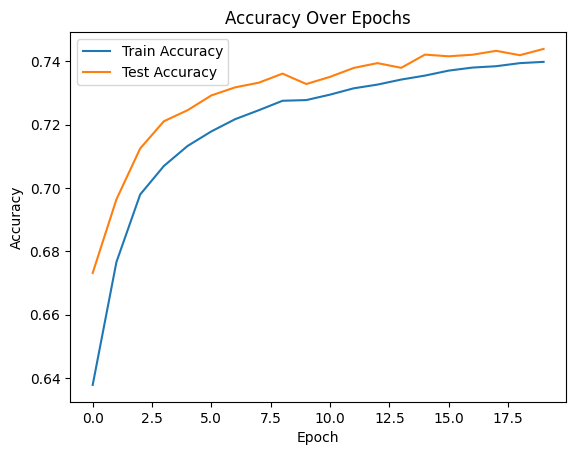

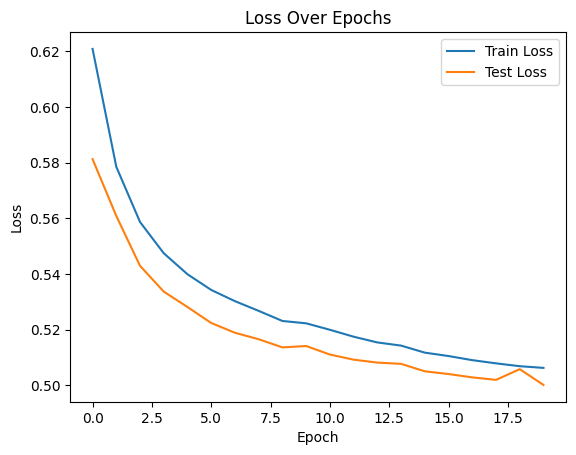

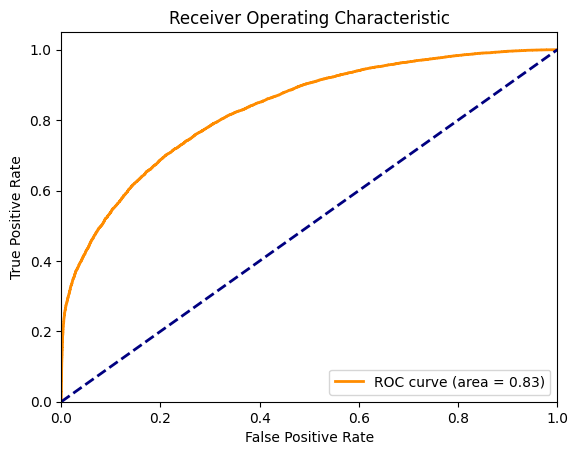

In [19]:
from sklearn.metrics import roc_curve, auc
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
# Create an instance of the CNN model
model = CNN()
model.to(device)
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
train_losses_per_epoch, train_accuracies_per_epoch = [], []
test_losses_per_epoch, test_accuracies_per_epoch = [], []
fpr_list, tpr_list, roc_auc_list = [], [], []  # For ROC curves

# Adjusted training loop
for epoch in range(num_epochs):
    model.train()
    total_loss, correct_predictions = 0, 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.float().to(device), labels.long().to(device)
        optimizer.zero_grad()
        
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        correct_predictions += (predicted == labels).sum().item()

    avg_train_loss = total_loss / len(train_loader.dataset)
    train_accuracy = correct_predictions / len(train_loader.dataset)
    train_losses_per_epoch.append(avg_train_loss)
    train_accuracies_per_epoch.append(train_accuracy)
    
    # Evaluate on test set after each epoch
    model.eval()
    total_loss, correct_predictions, all_targets, all_probabilities = 0, 0, [], []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.float().to(device), labels.long().to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            correct_predictions += (predicted == labels).sum().item()

            # For ROC curve
            probabilities = nn.functional.softmax(outputs, dim=1)[:, 1]
            all_probabilities.extend(probabilities.cpu().numpy())
            all_targets.extend(labels.cpu().numpy())

    avg_test_loss = total_loss / len(test_loader.dataset)
    test_accuracy = correct_predictions / len(test_loader.dataset)
    test_losses_per_epoch.append(avg_test_loss)
    test_accuracies_per_epoch.append(test_accuracy)

    # Calculate ROC AUC
    fpr, tpr, _ = roc_curve(all_targets, all_probabilities)
    roc_auc = auc(fpr, tpr)
    fpr_list.append(fpr)
    tpr_list.append(tpr)
    roc_auc_list.append(roc_auc)

    print(f"Epoch {epoch+1}/{num_epochs}:")
    print(f"Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")
    print(f"Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")
    print(f"ROC AUC: {roc_auc:.4f}\n")

# Plot training and test accuracies
plt.plot(train_accuracies_per_epoch, label='Train Accuracy')
plt.plot(test_accuracies_per_epoch, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Over Epochs')
plt.show()

# Plot training and test losses
plt.plot(train_losses_per_epoch, label='Train Loss')
plt.plot(test_losses_per_epoch, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Over Epochs')
plt.show()

# Plot the ROC curve (using the last epoch's data)
plt.plot(fpr_list[-1], tpr_list[-1], color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_list[-1]:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

Test Loss: 0.5002, Test Accuracy: 0.7438


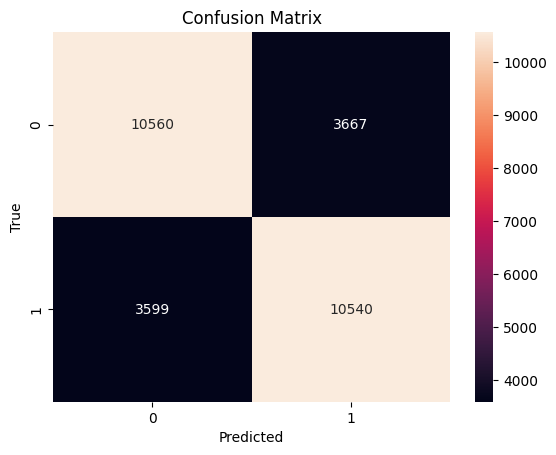

              precision    recall  f1-score   support

           0       0.75      0.74      0.74     14227
           1       0.74      0.75      0.74     14139

    accuracy                           0.74     28366
   macro avg       0.74      0.74      0.74     28366
weighted avg       0.74      0.74      0.74     28366



In [20]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

model.eval()  # Set the model to evaluation mode
total_loss = 0.0
correct_predictions = 0
all_predicted_labels = []
all_true_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.float().to(device), labels.long().to(device)
        
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        total_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs.data, 1)
        correct_predictions += (predicted == labels).sum().item()
        
        all_true_labels.extend(labels.cpu().numpy())
        all_predicted_labels.extend(predicted.cpu().numpy())

avg_loss = total_loss / len(test_loader.dataset)
accuracy = correct_predictions / len(test_loader.dataset)
# test_losses.append(avg_loss)
# test_accuracies.append(accuracy)

print(f"Test Loss: {avg_loss:.4f}, Test Accuracy: {accuracy:.4f}")

# Confusion matrix
confusion_mtx = confusion_matrix(all_true_labels, all_predicted_labels)
sns.heatmap(confusion_mtx, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Classification report
print(classification_report(all_true_labels, all_predicted_labels))

# Suggestions for further improvements in elegance:
# 1. Function Definitions: Consider defining functions for repetitive tasks like plotting or calculating metrics.
# 2. Early Stopping: Implement early stopping during training to prevent overfitting.
# 3. Logging: Use a logging library instead of print statements for better control over the logging level and formatting.



In [21]:
class_counts

label
enhP          141830
non-target    141830
Name: count, dtype: int64

In [22]:
class CRNN(nn.Module):
    def __init__(self):
        super(CRNN, self).__init__()
        self.conv1 = nn.Conv1d(4, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(16, 32, kernel_size=3, padding=1)
        self.rnn = nn.LSTM(input_size=32, hidden_size=64, num_layers=1, batch_first=True)
        self.fc = nn.Linear(64,2)
        self.pool = nn.MaxPool1d(2, 2)    
    def forward(self, x):
        x = self.pool(nn.functional.relu(self.conv1(x)))
        x = self.pool(nn.functional.relu(self.conv2(x)))
        x = x.permute(0,2,1)
        x, (hn, cn) = self.rnn(x)
        x = hn[-1,:,:]
        x = self.fc(x)
        return x

Epoch 1/20:
Train Loss: 0.6537, Train Accuracy: 0.6075
Test Loss: 0.6244, Test Accuracy: 0.6480
ROC AUC: 0.7132

Epoch 2/20:
Train Loss: 0.6075, Train Accuracy: 0.6469
Test Loss: 0.5925, Test Accuracy: 0.6534
ROC AUC: 0.7350

Epoch 3/20:
Train Loss: 0.5918, Train Accuracy: 0.6516
Test Loss: 0.5860, Test Accuracy: 0.6578
ROC AUC: 0.7407

Epoch 4/20:
Train Loss: 0.5848, Train Accuracy: 0.6577
Test Loss: 0.5788, Test Accuracy: 0.6659
ROC AUC: 0.7497

Epoch 5/20:
Train Loss: 0.5773, Train Accuracy: 0.6694
Test Loss: 0.5757, Test Accuracy: 0.6774
ROC AUC: 0.7651

Epoch 6/20:
Train Loss: 0.5645, Train Accuracy: 0.6871
Test Loss: 0.5547, Test Accuracy: 0.7026
ROC AUC: 0.7821

Epoch 7/20:
Train Loss: 0.5533, Train Accuracy: 0.7007
Test Loss: 0.5485, Test Accuracy: 0.7067
ROC AUC: 0.7890

Epoch 8/20:
Train Loss: 0.5466, Train Accuracy: 0.7067
Test Loss: 0.5383, Test Accuracy: 0.7151
ROC AUC: 0.7940

Epoch 9/20:
Train Loss: 0.5418, Train Accuracy: 0.7109
Test Loss: 0.5354, Test Accuracy: 0.7155


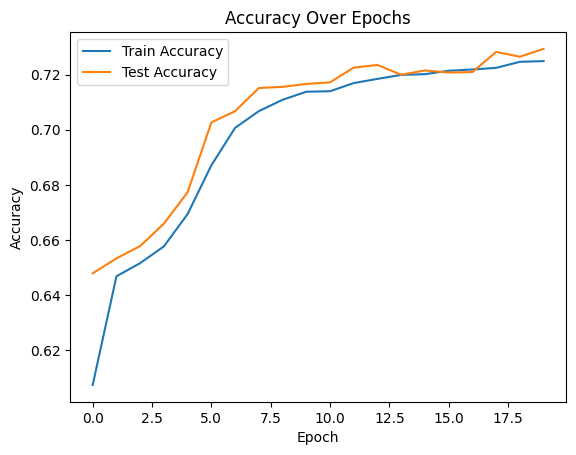

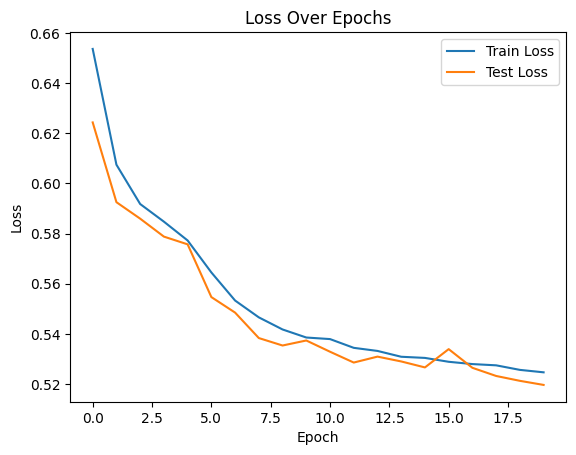

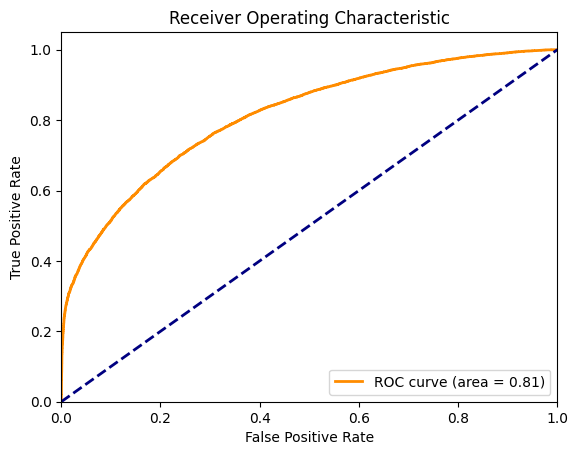

In [23]:
from sklearn.metrics import roc_curve, auc
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
# Create an instance of the CNN model
model = CRNN()
model.to(device)
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
train_losses_per_epoch, train_accuracies_per_epoch = [], []
test_losses_per_epoch, test_accuracies_per_epoch = [], []
fpr_list, tpr_list, roc_auc_list = [], [], []  # For ROC curves

# Adjusted training loop
for epoch in range(num_epochs):
    model.train()
    total_loss, correct_predictions = 0, 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.float().to(device), labels.long().to(device)
        optimizer.zero_grad()
        
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        correct_predictions += (predicted == labels).sum().item()

    avg_train_loss = total_loss / len(train_loader.dataset)
    train_accuracy = correct_predictions / len(train_loader.dataset)
    train_losses_per_epoch.append(avg_train_loss)
    train_accuracies_per_epoch.append(train_accuracy)
    
    # Evaluate on test set after each epoch
    model.eval()
    total_loss, correct_predictions, all_targets, all_probabilities = 0, 0, [], []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.float().to(device), labels.long().to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            correct_predictions += (predicted == labels).sum().item()

            # For ROC curve
            probabilities = nn.functional.softmax(outputs, dim=1)[:, 1]
            all_probabilities.extend(probabilities.cpu().numpy())
            all_targets.extend(labels.cpu().numpy())

    avg_test_loss = total_loss / len(test_loader.dataset)
    test_accuracy = correct_predictions / len(test_loader.dataset)
    test_losses_per_epoch.append(avg_test_loss)
    test_accuracies_per_epoch.append(test_accuracy)

    # Calculate ROC AUC
    fpr, tpr, _ = roc_curve(all_targets, all_probabilities)
    roc_auc = auc(fpr, tpr)
    fpr_list.append(fpr)
    tpr_list.append(tpr)
    roc_auc_list.append(roc_auc)

    print(f"Epoch {epoch+1}/{num_epochs}:")
    print(f"Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")
    print(f"Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")
    print(f"ROC AUC: {roc_auc:.4f}\n")

# Plot training and test accuracies
plt.plot(train_accuracies_per_epoch, label='Train Accuracy')
plt.plot(test_accuracies_per_epoch, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Over Epochs')
plt.show()

# Plot training and test losses
plt.plot(train_losses_per_epoch, label='Train Loss')
plt.plot(test_losses_per_epoch, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Over Epochs')
plt.show()

# Plot the ROC curve (using the last epoch's data)
plt.plot(fpr_list[-1], tpr_list[-1], color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_list[-1]:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

Test Loss: 0.5196, Test Accuracy: 0.7293


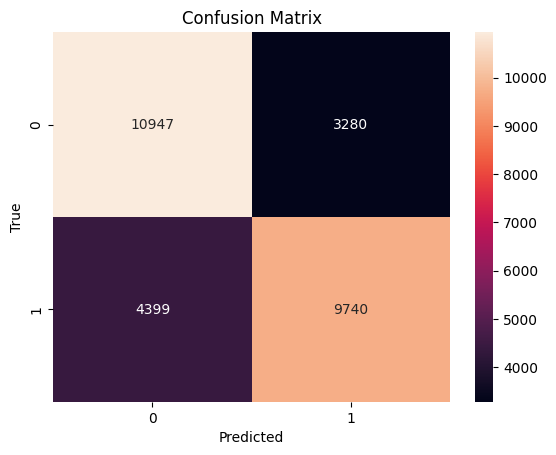

              precision    recall  f1-score   support

           0       0.71      0.77      0.74     14227
           1       0.75      0.69      0.72     14139

    accuracy                           0.73     28366
   macro avg       0.73      0.73      0.73     28366
weighted avg       0.73      0.73      0.73     28366



In [24]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

model.eval()  # Set the model to evaluation mode
total_loss = 0.0
correct_predictions = 0
all_predicted_labels = []
all_true_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.float().to(device), labels.long().to(device)
        
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        total_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs.data, 1)
        correct_predictions += (predicted == labels).sum().item()
        
        all_true_labels.extend(labels.cpu().numpy())
        all_predicted_labels.extend(predicted.cpu().numpy())

avg_loss = total_loss / len(test_loader.dataset)
accuracy = correct_predictions / len(test_loader.dataset)
# test_losses.append(avg_loss)
# test_accuracies.append(accuracy)

print(f"Test Loss: {avg_loss:.4f}, Test Accuracy: {accuracy:.4f}")

# Confusion matrix
confusion_mtx = confusion_matrix(all_true_labels, all_predicted_labels)
sns.heatmap(confusion_mtx, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Classification report
print(classification_report(all_true_labels, all_predicted_labels))

# Suggestions for further improvements in elegance:
# 1. Function Definitions: Consider defining functions for repetitive tasks like plotting or calculating metrics.
# 2. Early Stopping: Implement early stopping during training to prevent overfitting.
# 3. Logging: Use a logging library instead of print statements for better control over the logging level and formatting.

